# Modelo Deteccion de Emociones


In [3]:
import os
import librosa
import numpy as np

base_dir = "dataset"
labels = []
mfccs = []

def extract_emociones(nombre_archivo):
    return nombre_archivo.split("_")[0].lower()


for archivo in os.listdir(base_dir):
    if archivo.endswith(".wav"):
        ruta_archivo = os.path.join(base_dir, archivo)
        y, sr = librosa.load(ruta_archivo, sr=16000)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
        if mfcc.shape[1] < 174:
            mfcc = np.pad(mfcc, ((0, 0), (0, 174 - mfcc.shape[1])), mode='constant')
        else:
            mfcc = mfcc[:, :174]
        mfccs.append(mfcc.T)
        labels.append(extract_emociones(archivo))

print(f"Total audios: {len(mfccs)}")
print(f"Emociones encontradas: {set(labels)}")

Total audios: 862
Emociones encontradas: {'fear', 'neutral', 'happiness', 'anger', 'disgust', 'sadness'}


In [4]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

encoder = LabelEncoder()
y_encoded = encoder.fit_transform(labels)

y_onehot = to_categorical(y_encoded)


print("Primeras etiquetas codificadas:", y_encoded[:10])
print("Shape de etiquetas one-hot: ", y_onehot.shape)

Primeras etiquetas codificadas: [5 1 4 3 1 5 0 1 4 3]
Shape de etiquetas one-hot:  (862, 6)


In [5]:
from sklearn.model_selection import train_test_split
X = np.array(mfccs)
X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.2, random_state=42)   

print("Shape de X_train:", X_train.shape)
print("Shape de X_test:", X_test.shape) 
print("Shape de y_train:", y_train.shape)


Shape de X_train: (689, 174, 40)
Shape de X_test: (173, 174, 40)
Shape de y_train: (689, 6)


In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau



model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(X.shape[1], X.shape[2])),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.4),
    
    Conv1D(128, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.4),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(y_train.shape[1], activation='softmax')
])


model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
model.summary()

/home/jose/Desktop/IHC/Proyecto/venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_10 (Conv1D)              │ (None, 172, 64)        │         7,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 172, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_10 (MaxPooling1D) │ (None, 86, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 86, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 84, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 84, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_11 (MaxPooling1D) │ (None, 42, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 42, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 5376)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │       688,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 722,246 (2.76 MB)

 Trainable params: 721,862 (2.75 MB)

 Non-trainable params: 384 (1.50 KB)

In [24]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-5
)

In [25]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.1847 - loss: 3.5033 - val_accuracy: 0.3526 - val_loss: 1.7945 - learning_rate: 0.0010
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3341 - loss: 1.7043 - val_accuracy: 0.2948 - val_loss: 1.5650 - learning_rate: 0.0010
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3300 - loss: 1.6298 - val_accuracy: 0.4971 - val_loss: 1.4539 - learning_rate: 0.0010
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3622 - loss: 1.5743 - val_accuracy: 0.4798 - val_loss: 1.4695 - learning_rate: 0.0010
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.3959 - loss: 1.5168 - val_accuracy: 0.4509 - val_loss: 1.4072 - learning_rate: 0.0010
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.4016 - loss: 1.4407 - val_accuracy: 0.5318 - val_loss: 1.2974 - learning_rate: 0.0010
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.4451 - loss: 1.3640 - val_acc

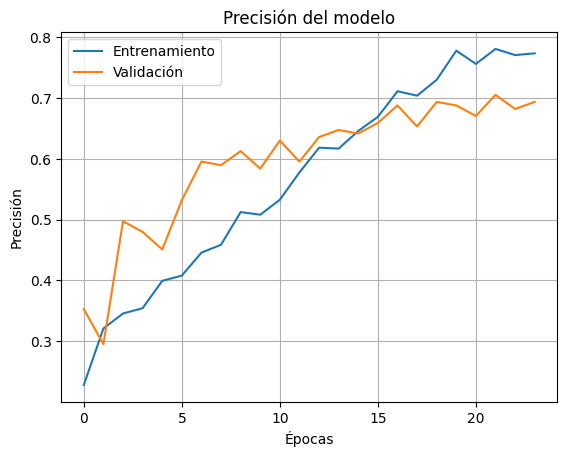

In [26]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión del modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.grid(True)
plt.show()

In [27]:
from sklearn.metrics import classification_report
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

print(classification_report(y_true, y_pred, target_names=encoder.classes_))

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
              precision    recall  f1-score   support

       anger       0.83      0.76      0.79        25
     disgust       0.82      0.60      0.69        30
        fear       0.44      0.48      0.46        23
   happiness       0.95      0.69      0.80        29
     neutral       0.58      0.91      0.71        32
     sadness       0.72      0.68      0.70        34

    accuracy                           0.69       173
   macro avg       0.72      0.69      0.69       173
weighted avg       0.73      0.69      0.70       173



In [28]:
model.save("modelo_emociones.h5")

In [39]:
import tensorflow as tf
import pickle


modelo = tf.keras.models.load_model("modelo_emociones.h5")
with open("encoder.pkl", "rb") as f:
    encoder = pickle.load(f)
    
def predecir_emocion(ruta_audio):
    y, sr = librosa.load(ruta_audio, sr=16000)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    if mfcc.shape[1] < 174:
        mfcc = np.pad(mfcc, ((0, 0), (0, 174 - mfcc.shape[1])), mode='constant')
    else:
        mfcc = mfcc[:, :174]
    entrada = mfcc.T.reshape(1, 174, 40) 
    pred = modelo.predict(entrada)
    clase = np.argmax(pred)
    emocion = encoder.inverse_transform([clase])[0]
    print(f"Emoción predicha: {emocion.upper()} con probabilidad {pred[0][clase]:.2f}")

predecir_emocion("audio_usuario.wav")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
Emoción predicha: DISGUST con probabilidad 1.00
